---
# Setup

### Imports

In [1]:
# - Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Utils
from typing import Dict, Optional, Tuple
import numpy as np
from tqdm import tqdm
from copy import deepcopy

# Jax Imports
import jax
from jax import numpy as jnp
from jax.example_libraries.optimizers import adam

# Rockpool Imports
from rockpool.nn.modules import LinearJax
from rockpool.nn.modules.jax.jax_lif_ode import LIFJax, LIFODEJax
from rockpool.nn.combinators import Sequential
from rockpool.timeseries import TSContinuous, TSEvent
from rockpool.parameters import Constant, SimulationParameter
from rockpool.nn.modules.jax.jax_module import JaxModule
import rockpool.training.jax_loss as l


# - Plotting and config
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100

Could not import package: 'numba' backend not found. Modules that rely on numba will not be available.
Could not import package: 'numba' backend not found. Modules that rely on numba will not be available.
Could not import package: No module named 'iaf_nest'


### Utilities

In [2]:
# @title Data Generation { display-mode: "form" }

def plot_signal(tensor: np.ndarray, name: str, unit: str, dt: float) -> None:
    """
    plot_signal converts a signal to a ``TSContinuous`` object and plots the result

    :param tensor: signal with shape (batch, time_steps, n_channels)
    :type tensor: np.ndarray
    :param name: name of the signal to be used as the title of the plot
    :type name: str
    :param unit: unit of measurement to label y axis
    :type unit: str
    :param dt: discrete time step length in seconds
    :type dt: float
    """
    Ix = TSContinuous.from_clocked(tensor.flatten(), dt=dt, name=name)
    plt.figure()
    plt.ylabel(unit)
    Ix.plot()

def poisson_spike_train(
    duration: float, rate: float, dt: float, seed: Optional[int] = None
) -> np.ndarray:
    """
    random_spike_train generates a Poisson frozen random spike train 

    :param duration: simulation duration in seconds
    :type duration: float
    :param rate: expected mean spiking rate in Hertz(1/s)
    :type rate: float
    :param dt: time step length
    :type dt: float, optional
    :raises ValueError: no spike generated due to low firing rate or very short simulation time]
    :return: randomly generated discrete spike train
    :rtype: np.ndarray
    """
    np.random.seed(seed)
    steps = int(np.round(duration / dt))
    raster = np.random.poisson(rate * dt, (1, steps, 1))

    # Check if raster has at least one spike
    if not any(raster.flatten()):
        raise ValueError(
            "No spike generated at all due to low firing rate or short simulation time duration!"
        )

    spike_tensor = np.array(raster, dtype=np.float)
    return spike_tensor

def plot_raster(tensor: np.ndarray, name: str, dt: float) -> None:
    """
    plot_raster converts a ``spikes`` record obtained from the record dictionary to a ``TSEvent`` object and plots the result

    :param tensor: spike raster with shape (batch, time_steps, n_channels)
    :type tensor: np.ndarray
    :param name: name of the spike raster for the title of the plot
    :type name: str
    :param dt: time step length in seconds
    :type dt: float
    """
    spikes_ts = TSEvent.from_raster(tensor.flatten(), dt=dt, name=name)
    plt.figure()
    spikes_ts.plot()

def plot_LIF_record(
    rec: Dict[str, np.ndarray],
    dt: float,
    plot_Vmem: bool = True,
    plot_Isyn: bool = True,
    plot_spikes: bool = True,
    plot_Irec: bool = False,
    Vth: Optional[float] = None,
) -> None:
    """
    plot_LIF_record takes an ``LIFTorch`` record dictionary and plots the signals and the spike raster

    :param rec: ``LIFTorch`` record dictionary
    :type rec: Dict[str, np.ndarray]
    :param dt: time step length in seconds
    :type dt: float, optional
    :param plot_Vmem: plot membrane potential or not, defaults to True
    :type plot_Vmem: bool, optional
    :param plot_Isyn: plot external synaptic current or not, defaults to True
    :type plot_Isyn: bool, optional
    :param plot_spikes: plot spiking output or not, defaults to True
    :type plot_spikes: bool, optional
    :param plot_Irec: plot recurrent synaptic current or not, defaults to False
    :type plot_Irec: bool, optional
    :param Vth: spiking threshold of the membrane potential. Plot if not None, defaults to None
    :type Vth: Optional[float], optional
    """

    # Recurrent synaptic current
    if plot_Irec:
        plot_signal(rec["irec"], "$I_{rec}$", "Current", dt)

    # External synaptic current
    if plot_Isyn:
        plot_signal(rec["isyn"], "$I_{syn}$", "Current", dt)

    # Membrane potential
    if plot_Vmem:
        vmem = rec["vmem"]
        plot_signal(vmem, "$V_{mem}$", "Voltage", dt)

        # Spike threshold
        if Vth is not None:
            _vth = np.ones_like(vmem.flatten()) * Vth
            _vth = TSContinuous.from_clocked(_vth, dt=dt)
            _vth.plot(linestyle="dashed")

    # Spike output
    if plot_spikes:
        plot_raster(rec["spikes"], "Output Spikes", dt)

In [3]:
# class RateReadout(JaxModule):
#     """
#     RateReadout implements a custom layer which measures the firing rate of the upstream spiking layer

#     :Output:

#     .. math ::

#         r = \dfrac{\sum_{t=0}^{T} S_{rec}}{T}

#     :param shape: shape of the layer ``(Nin, Nout)``
#     :type shape: tuple
#     :param dt: time step length in seconds
#     :type dt: float, optional
#     :raises ValueError: `shape` must specify input and output size for RateReadout
#     """

#     def __init__(self, shape: Tuple[int], dt: float = 1e-3, *args, **kwargs) -> None:
#         """
#         __init__ Initialize ``RateReadout`` module. Parameters are explained in the class docstring.

#         """
#         super().__init__(shape=shape, *args, **kwargs)

#         if len(self.shape) != 2:
#             raise ValueError(
#                 "`shape` must specify input and output size for RateReadout."
#             )

#         self.dt = SimulationParameter(dt)

#     def evolve(self, data: jnp.ndarray, record : bool = False) -> jnp.ndarray:
#         """
#         forward processing data through this layer, calculates the firing rate

#         :param data: spike train data taking the shape of (batch, time_steps, n_synapses)
#         :type data: torch.Tensor
#         :return: firing rate response of the previous spiking layer with the shape of (batch, 1, n_synapses)
#         :rtype: torch.Tensor
#         """
#         data, _ = self._auto_batch(data)

#         n_batch, n_timesteps, n_channel = data.shape
#         rate = jnp.sum(data, axis=1) / (n_timesteps * self.dt)
#         return rate, _, _

## Model Implementation

In [4]:
# --- Input Layer --- #
linear = LinearJax(
    shape=(1, 1),
    weight=jnp.array([[0.02]]),
    has_bias=False,
)

In [5]:
# --- LIF Layer --- #
dt = 1e-3
Vth = Constant(1.0)

lif = LIFJax(
    shape=(1, 1),
    tau_mem=Constant(0.03),
    tau_syn=Constant(0.01),
    bias=Constant(0.0),
    threshold=Vth,
    noise_std = 0.0,
    dt=dt,
)

In [6]:
# --- Readout Layer --- #
# readout = RateReadout(shape=(1, 1), dt=dt)

# --- Model --- #
model = Sequential(linear, lif)
model

JaxSequential  with shape (1, 1) {
    LinearJax '0_LinearJax' with shape (1, 1)
    LIFJax '1_LIFJax' with shape (1, 1)
}

In [7]:
model_jit = jax.jit(model)

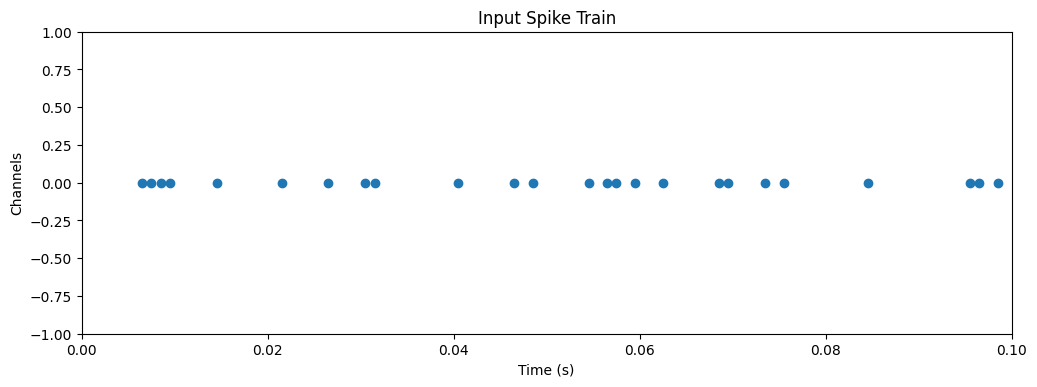

In [8]:
spike_ts = poisson_spike_train(duration=100e-3, rate=200.0, dt=dt, seed=2022)

plot_raster(spike_ts, "Input Spike Train", dt)

Now let's run the model and record the state changes over time

In [9]:
# Run!
model.reset_state()
rate_out, state, record_dict = model(spike_ts, record = True)

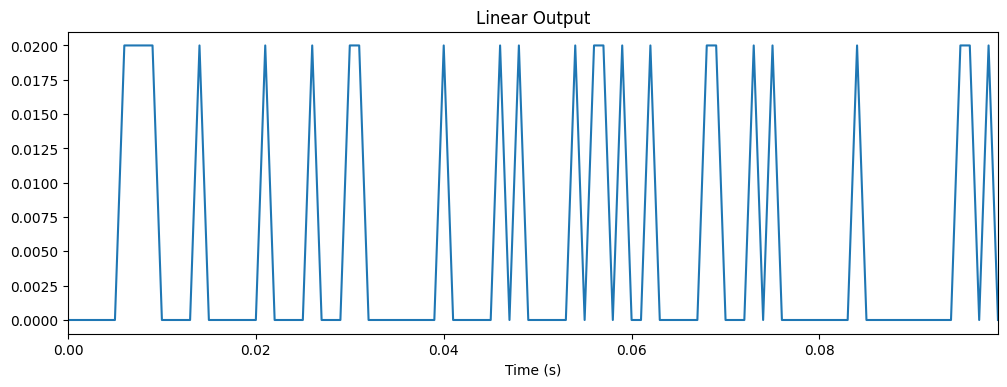

In [10]:
plot_signal(record_dict["0_LinearJax_output"], "Linear Output", "", dt)

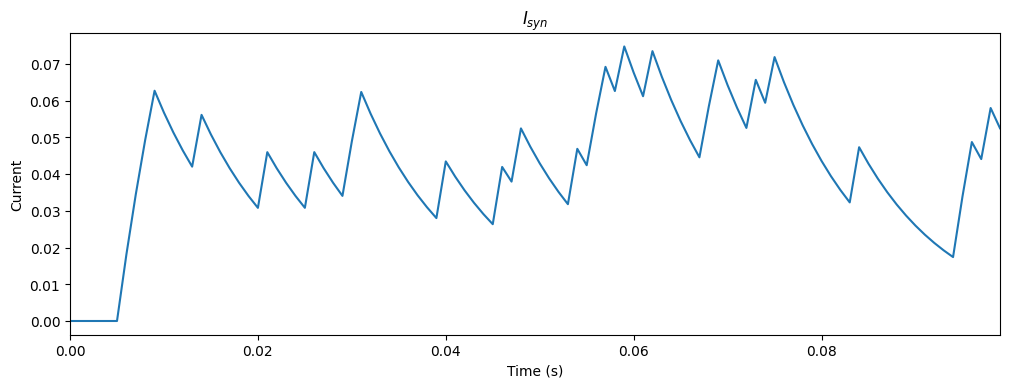

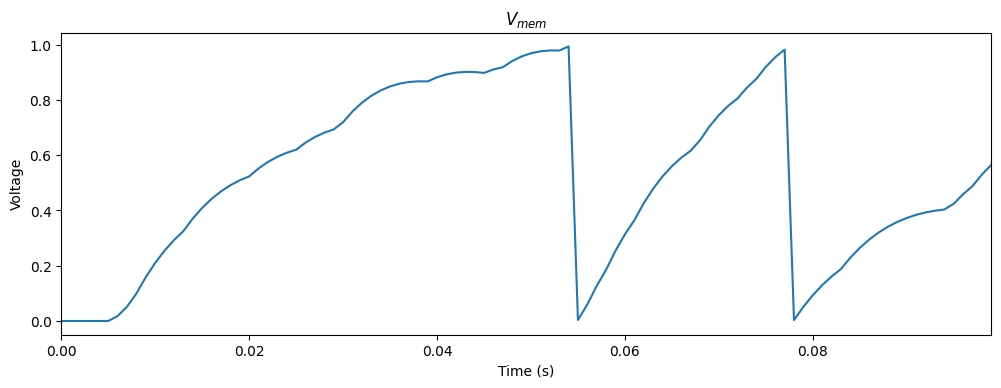

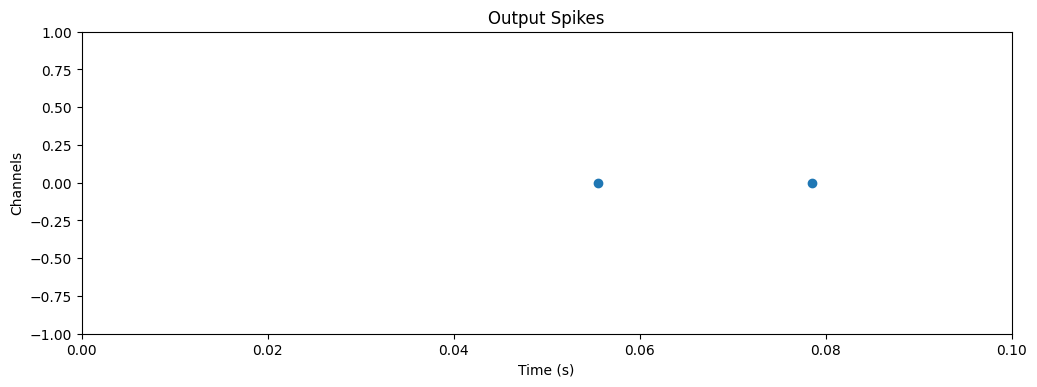

In [11]:
plot_LIF_record(record_dict['1_LIFJax'], dt=dt)

In [12]:
print(rate_out)

[[[0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]]


---
## Section 3: Define the Optimization Task

We want the neuron to fire at 50 Hz given the 200 Hz input. In order to arrive at this target firing rate, we need to define a loss function, such that minimising the loss will lead to our desired output rate.

### Section 3.1 : Target

Here we define the target firing rate.

In [13]:
target = 50.0

### Section 3.2 : Loss Function

We use Mean squared error (MSE), which is one of the most commonly used loss function for regression tasks in machine learning. The loss is given by the mean of the squared differences between true and predicted values for the rate of the neuron.

MSE Loss : $ l = (r - \hat{r})^ 2 $

In [14]:
# - Define a loss function
def loss_mse(params, net, input, target):
    # - Reset the network state
    net = net.reset_state()
    # jax.block_until_ready(net)
    
    # - Apply the parameters
    net = net.set_attributes(params)
    # jax.block_until_ready(net)
    
    # - Evolve the network
    output, _, _ = net(input, record = False)
    # jax.block_until_ready(output)

    rate = jnp.sum(output) / (100 * 1e-3)
    # jax.block_until_ready(rate)
    # # - Impose the bounds
    # bounds = bounds_cost(params, lower_bounds, upper_bounds)

    # - Return the loss
    return l.mse(rate, target)

In [15]:
_loss_trace = []
_grad_trace = []

loss_vgf = jax.jit(jax.value_and_grad(loss_mse))
# loss_vgf = jax.value_and_grad(loss_mse)

W = np.linspace(-0.05, 0.1, 200, dtype=np.float32)


# Sweep over the weights
for w in tqdm(W):
     # Redefine the model with a different input weight
     lin = LinearJax((1, 1), weight = jnp.array([[w]]), has_bias=False)
     lif = LIFJax(
          shape=(1, 1),
          tau_mem=Constant(0.03),
          tau_syn=Constant(0.01),
          bias=Constant(0.0),
          threshold=Constant(1.0),
          noise_std = 0.0,
          dt=dt,
     )
     model = Sequential(lin, lif)

     # - Get the loss value and gradients for this iteration
     loss_val, grads = loss_vgf(model.parameters(), model, spike_ts, target)

     _loss_trace.append(loss_val.item())
     _grad_trace.append(grads['0_LinearJax']['weight'].item())

100%|██████████| 200/200 [00:01<00:00, 184.03it/s]


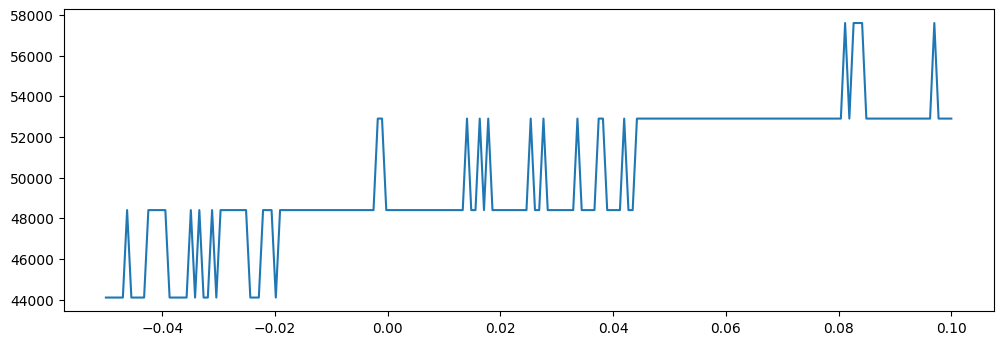

In [16]:
# surrogate_loss = np.cumsum(np.array(_grad_trace).flatten()*(W[1]-W[0]))
# surrogate_loss = surrogate_loss - np.min(surrogate_loss) + np.min(_loss_trace)

plt.figure()
plt.plot(W, _loss_trace, label = "Actual Loss")
# plt.plot(W, surrogate_loss, label = "Approximate Loss")
# plt.xlabel("Input Weight")
# plt.ylabel("Loss")
# plt.legend();

---
## Section 4 : Training a Spiking Neural Network

So far we have explored spiking rockpool modules and now we're ready to optimize our network. Let's first re-initialize the linear layer.

In [17]:
# Reinitialize the weight matrix

# TODO : Change the weight to see what happens
# TODO : What happens if we initialize the input weights very close to 0?


# --- Input Layer --- #
linear = LinearJax(
    shape=(1, 1),
    weight=jnp.array([[20.0]]),
    has_bias=False,
)

# lif = LIFODEJax(
#     shape=(1, 1),
#     tau_mem=Constant(0.03),
#     tau_syn=Constant(0.01),
#     bias=Constant(0.0),
#     threshold=Constant(1.0),
#     noise_std = 0.0,
#     dt=dt,
# )
# readout = RateReadout(shape=(1, 1), dt=dt)

# --- Model --- #
model = Sequential(linear, lif)
model

JaxSequential  with shape (1, 1) {
    LinearJax '0_LinearJax' with shape (1, 1)
    LIFJax '1_LIFJax' with shape (1, 1)
}

### Section 4.1 : Training Loop

We are using the MSE loss and the Adam optimizer for training. The workflow is similar to the native `torch` API.

In [18]:
model

JaxSequential  with shape (1, 1) {
    LinearJax '0_LinearJax' with shape (1, 1)
    LIFJax '1_LIFJax' with shape (1, 1)
}

In [19]:
_params = model.parameters()

params0 = {'0_LinearJax': _params['0_LinearJax'],
    '1_LIFODEJax': {}}

params0

{'0_LinearJax': {'weight': DeviceArray([[20.]], dtype=float32)},
 '1_LIFODEJax': {}}

In [20]:
# - Initialise the optimiser with the initial parameters
# - Get the optimiser functions
init_fun, update_fun, get_params = adam(1e-1)
params0 = deepcopy(params0)
opt_state = init_fun(params0)

# - Get a compiled value-and-gradient function
loss_vgf = jax.jit(jax.value_and_grad(loss_mse))

# - Compile the optimiser update function
update_fun = jax.jit(update_fun)

# - Record the loss values over training iterations
loss_t = []
grad_t = []

num_epochs = 300

In [21]:
get_params(opt_state)

{'0_LinearJax': {'weight': array([[20.]], dtype=float32)}, '1_LIFODEJax': {}}

In [22]:
# - Loop over iterations
for i_trial in tqdm(range(num_epochs)):
    # - Get parameters for this iteration
    params = get_params(opt_state)

    # - Get the loss value and gradients for this iteration
    loss_val, grads = loss_vgf(params, model, spike_ts, target)

    # - Update the optimiser
    opt_state = update_fun(i_trial, grads, opt_state)
    # - Keep track of the loss
    loss_t.append(loss_val.item())
    
print((loss_t[-1]))

100%|██████████| 300/300 [00:00<00:00, 648.53it/s]

2500.0


In [23]:
get_params(opt_state)

{'0_LinearJax': {'weight': DeviceArray([[nan]], dtype=float32)},
 '1_LIFODEJax': {}}

### Section 4.2 : Results

Let's check what happened during and after training. First we can see that the loss converges to zero. 

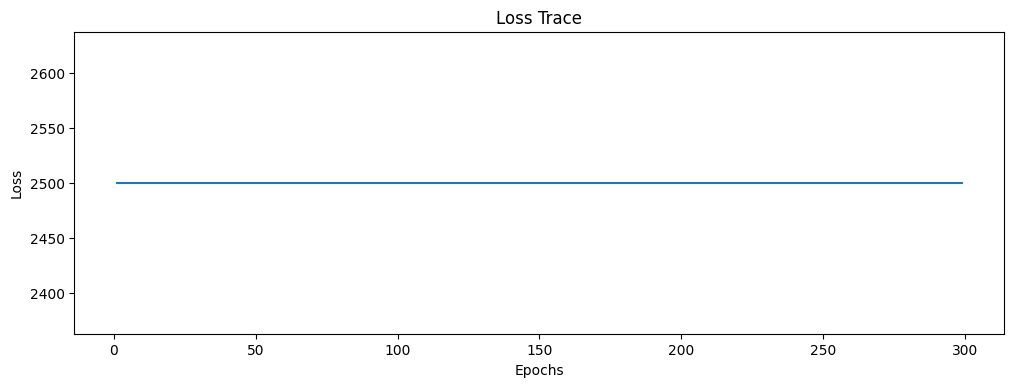

In [24]:
plt.plot(loss_t)
plt.title("Loss Trace")
plt.xlabel("Epochs")
plt.ylabel("Loss");

How did this happen? Inside the training loop, Adam continuously updated the weight parameter in the direction of the minimal loss.

Finally, let's run the optimized module and prove that it expresses a firing rate of 50 Hz.

In [25]:
model = model.set_attributes(get_params(opt_state))
# model.reset_state()
out, state, rec = model(spike_ts, record=True)
plot_LIF_record(rec['1_LIFODEJax'], dt=dt, Vth=Vth)

KeyError: '1_LIFODEJax'

See that the rate reading is 50. 

In [ ]:
model

JaxSequential  with shape (1, 1) {
    LinearJax '0_LinearJax' with shape (1, 1)
    LIFODEJax '1_LIFODEJax' with shape (1, 1)
    LinearJax '0_LinearJax' with shape (1, 1)
    LIFODEJax '1_LIFODEJax' with shape (1, 1)
}

In [ ]:
model.parameters()

{'0_LinearJax': {'weight': DeviceArray([[7.7928534]], dtype=float32)},
 '1_LIFODEJax': {}}